In [1]:
import pandas as pd
import re
import numpy as np
from scipy.stats import skew
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
data="../Data/HateSpeechData.xlsx"
dataset= pd.read_excel(data)

In [3]:
print("dataset shape:", dataset.shape)
dataset.head()

dataset shape: (46682, 7)


,Comment,Hate/NoHate,Insult,Violence,Sexual,Racism,Religious
0,भाक भोसडीके,1,0,0,0,0,0
1,पिक्चर स्पीक्स वाक मुजी,1,1,0,0,0,0
2,हे मुजी....,1,0,0,0,0,0
3,लस्तैइ ह्यान्डसम के मुजी 🤣❤️❤️❤️,1,1,0,0,0,0
4,आयो एमजी को कडा पर्सुस्तति♥️♥️♥️,1,0,0,0,0,0


In [4]:
dataset.info()
print("\nMissing values per column:")
print(dataset.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46682 entries, 0 to 46681
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Comment      46681 non-null  object
 1   Hate/NoHate  46682 non-null  int64 
 2   Insult       46682 non-null  int64 
 3   Violence     46682 non-null  int64 
 4   Sexual       46682 non-null  int64 
 5   Racism       46682 non-null  int64 
 6   Religious    46682 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 2.5+ MB

Missing values per column:
1


Exploratory Data Analysis (EDA)
Target Variable Distribution

/var/folders/mp/py4ff1r97335nwgzfbn_c_bh0000gn/T/ipykernel_84013/2120733313.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


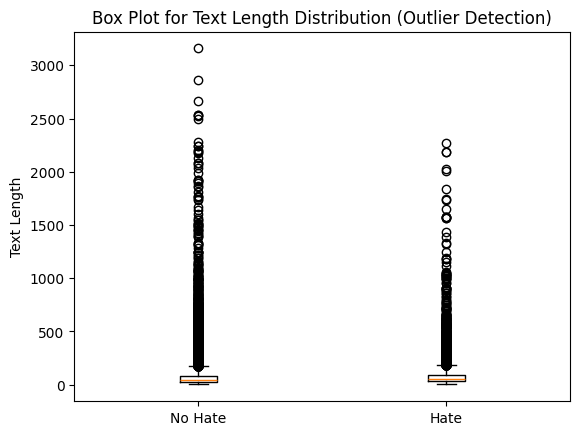

In [7]:
# Use original text column safely
dataset['text_length'] = dataset['Comment'].apply(lambda x: len(str(x)))

# Hate vs No Hate
hate_text_length = dataset[dataset['Hate/NoHate'] == 1]['text_length']
no_hate_text_length = dataset[dataset['Hate/NoHate'] == 0]['text_length']

plt.figure()
plt.boxplot(
    [no_hate_text_length, hate_text_length],
    labels=['No Hate', 'Hate'],
    showfliers=True
)

plt.ylabel("Text Length")
plt.title("Box Plot for Text Length Distribution (Outlier Detection)")
plt.show()

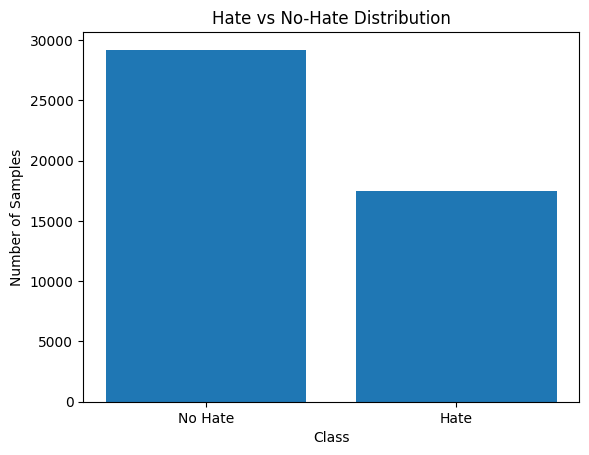

In [5]:
# Count hate vs no-hate
hate_counts = dataset['Hate/NoHate'].value_counts()

plt.figure()
plt.bar(['No Hate', 'Hate'], hate_counts.sort_index())
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Hate vs No-Hate Distribution")
plt.show()

In [12]:
counts = dataset["Hate/NoHate"].value_counts().sort_index()

# percentages
percent = counts / len(dataset) * 100
print(percent)

Hate/NoHate
0    62.570156
1    37.429844
Name: count, dtype: float64


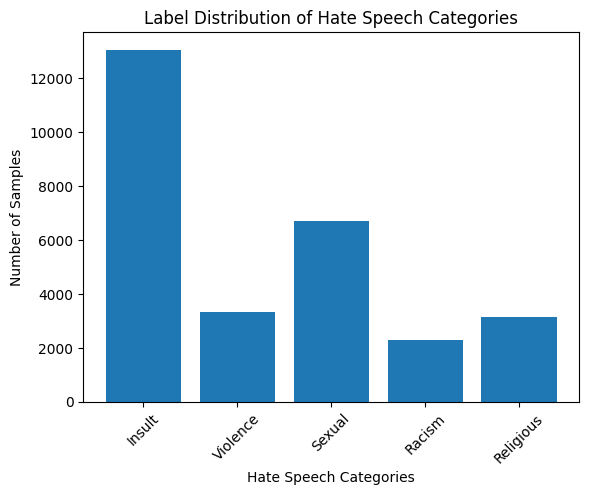

In [6]:
label_cols = ['Insult', 'Violence', 'Sexual', 'Racism', 'Religious']
label_counts = dataset[label_cols].sum()

plt.figure()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Hate Speech Categories")
plt.ylabel("Number of Samples")
plt.title("Label Distribution of Hate Speech Categories")
plt.xticks(rotation=45)
plt.show()

In [16]:
label_cols = ["Insult", "Violence", "Sexual", "Racism", "Religious"]

# only hate comments
hate_df = dataset[dataset["Hate/NoHate"] == 1]

category_counts = hate_df[label_cols].sum().sort_values(ascending=False)


# percentages within hate
category_percent = category_counts / len(hate_df) * 100
print(category_percent)


Insult       74.732444
Sexual       38.459337
Violence     19.075145
Religious    17.930521
Racism       13.083042
dtype: float64


Pure hate: 1080
Hate with subtype: 16393


/var/folders/mp/py4ff1r97335nwgzfbn_c_bh0000gn/T/ipykernel_84013/1799962043.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hate_df["any_subtype"] = hate_df[label_cols].sum(axis=1)


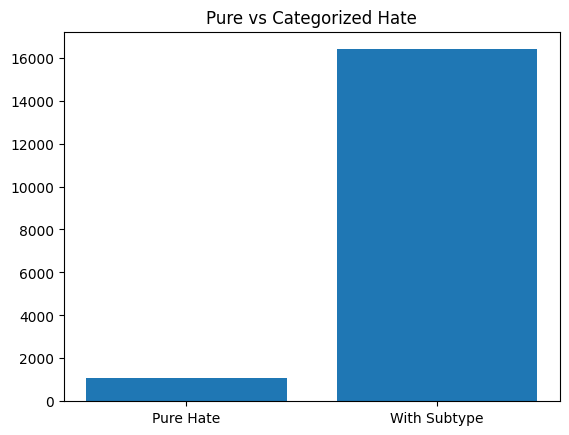

In [17]:
hate_df["any_subtype"] = hate_df[label_cols].sum(axis=1)

pure_hate = (hate_df["any_subtype"] == 0).sum()
with_subtype = (hate_df["any_subtype"] > 0).sum()

print("Pure hate:", pure_hate)
print("Hate with subtype:", with_subtype)

plt.bar(["Pure Hate", "With Subtype"], [pure_hate, with_subtype])
plt.title("Pure vs Categorized Hate")
plt.show()


/var/folders/mp/py4ff1r97335nwgzfbn_c_bh0000gn/T/ipykernel_84013/1022699497.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


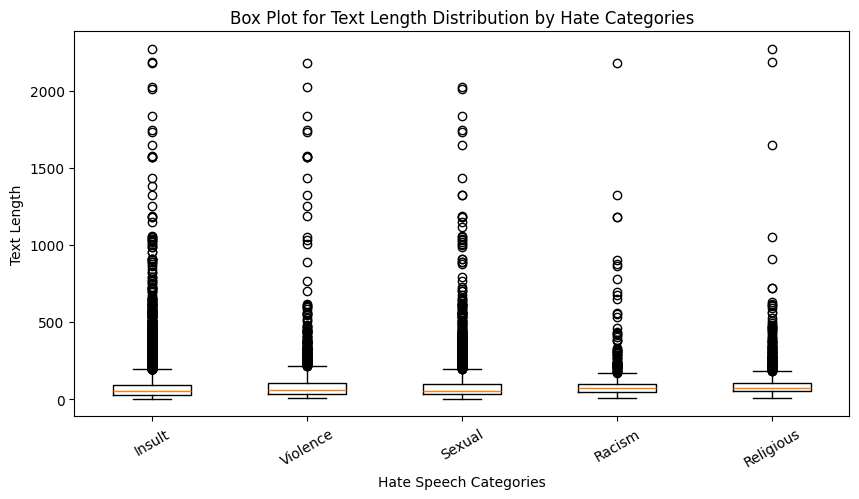

In [8]:
label_cols = ['Insult', 'Violence', 'Sexual', 'Racism', 'Religious']
label_text_lengths = []

for label in label_cols:
    lengths = dataset[dataset[label] == 1]['text_length']
    label_text_lengths.append(lengths)

plt.figure(figsize=(10,5))
plt.boxplot(
    label_text_lengths,
    labels=label_cols,
    showfliers=True
)

plt.ylabel("Text Length")
plt.xlabel("Hate Speech Categories")
plt.title("Box Plot for Text Length Distribution by Hate Categories")
plt.xticks(rotation=30)
plt.show()

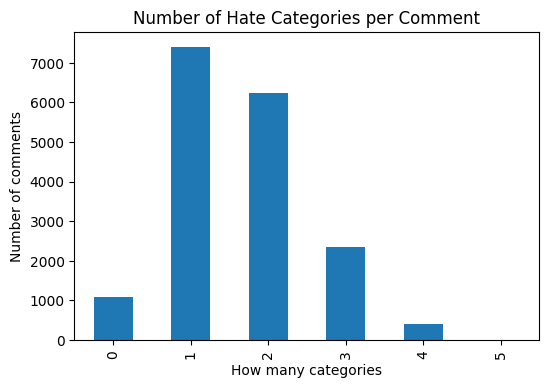

In [18]:
multi_counts = hate_df[label_cols].sum(axis=1)

plt.figure(figsize=(6,4))
multi_counts.value_counts().sort_index().plot(kind="bar")
plt.title("Number of Hate Categories per Comment")
plt.xlabel("How many categories")
plt.ylabel("Number of comments")
plt.show()


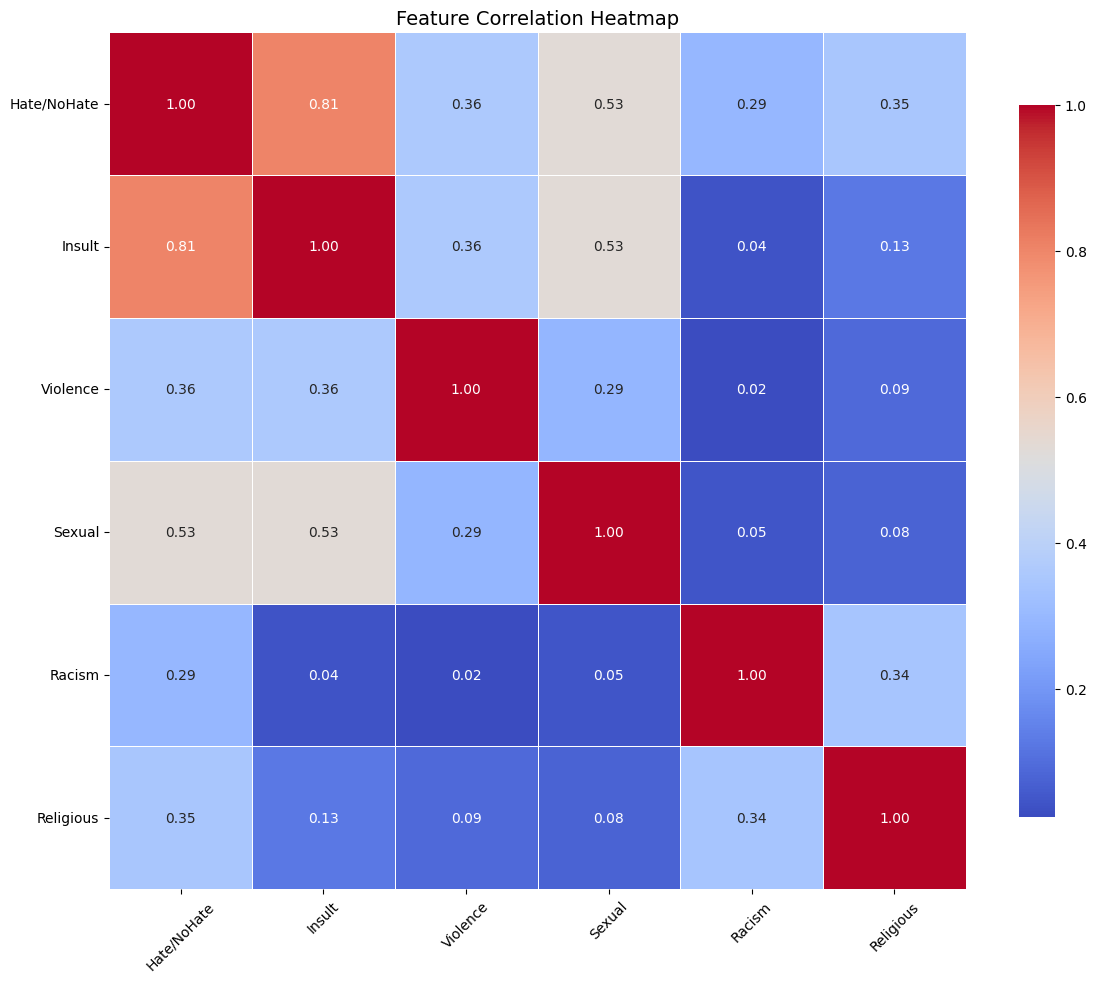

In [9]:
import seaborn as sns

# Select only numeric columns
numeric_cols = [
    'Hate/NoHate',
    'Insult',
    'Violence',
    'Sexual',
    'Racism',
    'Religious',
]

corr = dataset[numeric_cols].corr()
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

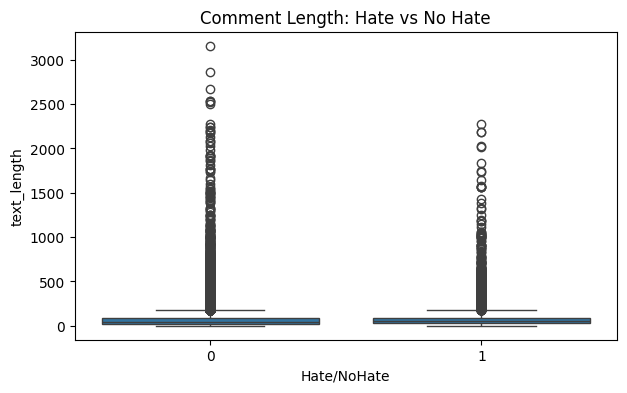

               count       mean         std  min   25%   50%   75%     max
Hate/NoHate                                                               
0            29209.0  78.170290  129.204608  1.0  25.0  44.0  85.0  3158.0
1            17473.0  77.245808  101.953477  2.0  30.0  52.0  90.0  2270.0


In [20]:

dataset["Comment"] = dataset["Comment"].astype(str)
dataset["text_length"] = dataset["Comment"].str.len()

plt.figure(figsize=(7,4))
sns.boxplot(x="Hate/NoHate", y="text_length", data=dataset)
plt.title("Comment Length: Hate vs No Hate")
plt.show()

print(dataset.groupby("Hate/NoHate")["text_length"].describe())


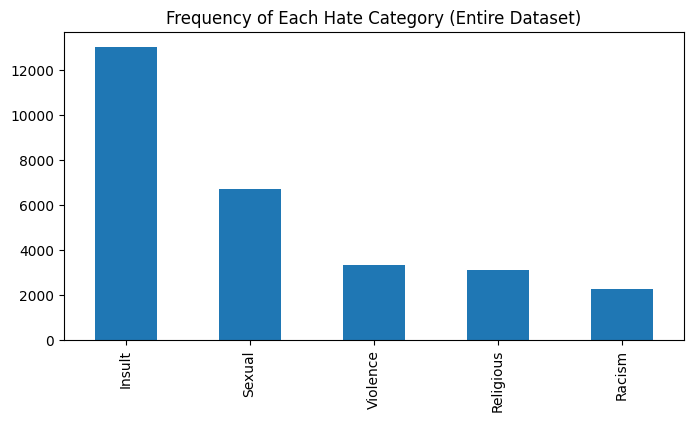

In [22]:
overall = dataset[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
overall.plot(kind="bar")
plt.title("Frequency of Each Hate Category (Entire Dataset)")
plt.show()


In [23]:
problem = dataset[(dataset[label_cols].sum(axis=1) > 0) & (dataset["Hate/NoHate"] == 0)]
print("Potential inconsistent rows:", len(problem))
problem.head()


Potential inconsistent rows: 0


,Comment,Hate/NoHate,Insult,Violence,Sexual,Racism,Religious,text_length


script
Bengali        34922
Devanagari     11639
Roman/Other      121
Name: count, dtype: int64


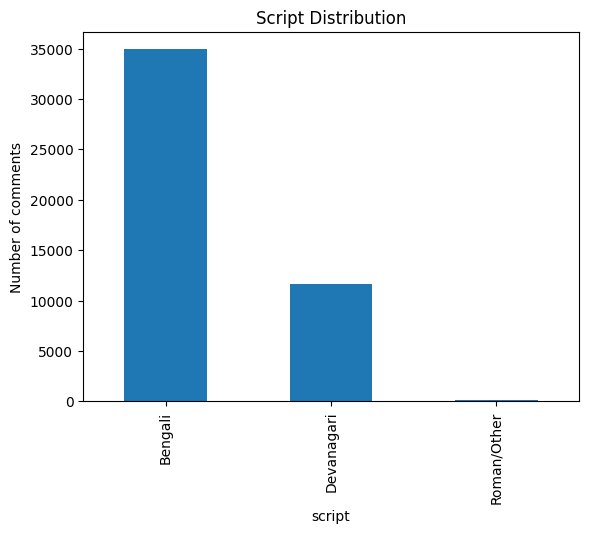

In [24]:


def detect_script(text):
    text = str(text)
    if re.search(r'[\u0980-\u09FF]', text):
        return "Bengali"
    elif re.search(r'[\u0900-\u097F]', text):
        return "Devanagari"
    else:
        return "Roman/Other"

dataset["script"] = dataset["Comment"].apply(detect_script)

print(dataset["script"].value_counts())

import matplotlib.pyplot as plt
dataset["script"].value_counts().plot(kind="bar")
plt.title("Script Distribution")
plt.ylabel("Number of comments")
plt.show()


script
Bengali        39.871714
Devanagari     30.432168
Roman/Other     5.785124
Name: Hate/NoHate, dtype: float64


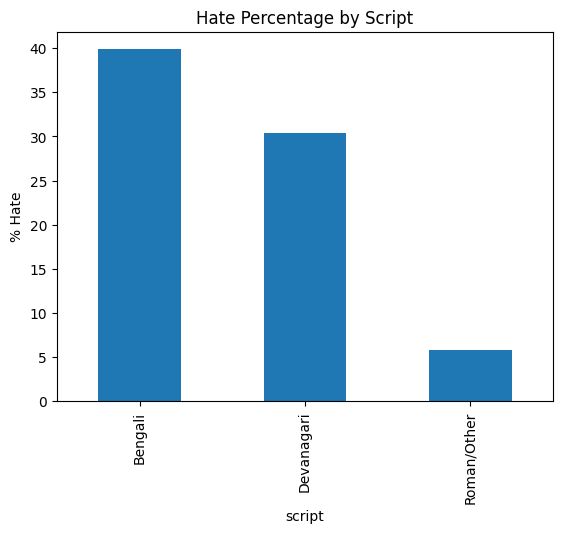

In [25]:
script_hate = dataset.groupby("script")["Hate/NoHate"].mean() * 100
print(script_hate)

script_hate.plot(kind="bar")
plt.title("Hate Percentage by Script")
plt.ylabel("% Hate")
plt.show()


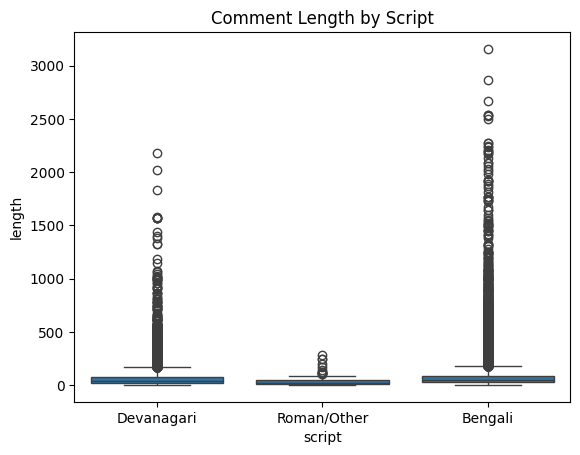

In [27]:
dataset["length"] = dataset["Comment"].astype(str).str.len()

import seaborn as sns
sns.boxplot(x="script", y="length", data=dataset)
plt.title("Comment Length by Script")
plt.show()


In [28]:
# exact duplicates
dups = dataset["Comment"].duplicated().sum()
print("Exact duplicates:", dups)

# see them
dataset[dataset["Comment"].duplicated(keep=False)].head()


Exact duplicates: 179


,Comment,Hate/NoHate,Insult,Violence,Sexual,Racism,Religious,text_length,script,length
11793,বদমাইশ,0,0,0,0,0,0,6,Bengali,6
11953,অসাধারণ,0,0,0,0,0,0,7,Bengali,7
12016,হাহাহাহা,0,0,0,0,0,0,8,Bengali,8
12112,বালের খবর,1,1,0,0,0,0,9,Bengali,9
12258,হাই,0,0,0,0,0,0,3,Bengali,3


In [29]:
conflict = dataset.groupby("Comment")["Hate/NoHate"].nunique()
problem = conflict[conflict > 1]

print("Conflicting labels:", len(problem))


Conflicting labels: 11


In [30]:
dataset["word_count"] = dataset["Comment"].astype(str).str.split().str.len()

print(dataset["word_count"].describe())

# look at top long ones
dataset.sort_values("word_count", ascending=False)[["Comment","word_count"]].head()


count    46682.000000
mean        14.033418
std         20.608243
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        537.000000
Name: word_count, dtype: float64


,Comment,word_count
22737,আপনার শুরু থেকে আসি তাহসিনেশন। দেওয়ানবাগী হুজু...,537
4297,हेल्लो है बताने भाइ कैसे हो आप आशा कर्ता हुन अ...,491
27244,"পরম শ্রদ্ধেয় স্যার, একটা বিষয় বাদে আপনার সব ব...",487
23715,মিয়ানমারের মতো মিলিটারি ডিক্টেটরের দেশের মানুষ...,462
28273,ড. মুহাম্মদ জাফর ইকবাল. তিনি ১৯৫২ সালের এই দি...,440


In [31]:
dataset["clean"] = dataset["Comment"].astype(str).str.strip()
bad = dataset[dataset["clean"].str.len() < 3]

print("Too short:", len(bad))


Too short: 51


In [32]:
label_cols = ["Insult","Violence","Sexual","Racism","Religious"]
dataset["num_labels"] = dataset[label_cols].sum(axis=1)

dataset["num_labels"].value_counts().sort_index()


num_labels
0    30289
1     7410
2     6239
3     2338
4      402
5        4
Name: count, dtype: int64

In [33]:
for c in label_cols:
    print(c, round(dataset[c].mean()*100,2), "%")


Insult 27.97 %
Violence 7.14 %
Sexual 14.4 %
Racism 4.9 %
Religious 6.71 %


In [34]:
unique_words = set()

for text in dataset["Comment"].astype(str):
    unique_words.update(text.split())

print("Total unique tokens:", len(unique_words))


Total unique tokens: 100796


In [35]:
dataset.groupby(pd.qcut(dataset["word_count"], 5))["Hate/NoHate"].mean()


/var/folders/mp/py4ff1r97335nwgzfbn_c_bh0000gn/T/ipykernel_84013/2462744462.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset.groupby(pd.qcut(dataset["word_count"], 5))["Hate/NoHate"].mean()


word_count
(0.999, 4.0]     0.303846
(4.0, 7.0]       0.362753
(7.0, 11.0]      0.400836
(11.0, 18.0]     0.434051
(18.0, 537.0]    0.380937
Name: Hate/NoHate, dtype: float64

In [36]:
import itertools

for a, b in itertools.combinations(label_cols, 2):
    overlap = ((dataset[a]==1) & (dataset[b]==1)).sum()
    if overlap > 0:
        print(a, "&", b, ":", overlap)


Insult & Violence : 2866
Insult & Sexual : 5776
Insult & Racism : 826
Insult & Religious : 1538
Violence & Sexual : 1696
Violence & Racism : 228
Violence & Religious : 500
Sexual & Racism : 494
Sexual & Religious : 763
Racism & Religious : 1018


In [37]:
# short hate
dataset[(dataset["word_count"] <= 3) & (dataset["Hate/NoHate"]==1)].head()

# long non-hate
dataset[(dataset["word_count"] > 30) & (dataset["Hate/NoHate"]==0)].head()


,Comment,Hate/NoHate,Insult,Violence,Sexual,Racism,Religious,text_length,script,length,word_count,clean,num_labels
252,पत्रकार निष्पक्ष हन्छ भन्थे तर हाम्राे देश नेप...,0,0,0,0,0,0,927,Devanagari,927,166,पत्रकार निष्पक्ष हन्छ भन्थे तर हाम्राे देश नेप...,0
290,"श्रीन्खला खतिवडा अहिलेको भारतीय बुहारी, अस्ति...",0,0,0,0,0,0,281,Devanagari,281,48,"श्रीन्खला खतिवडा अहिलेको भारतीय बुहारी, अस्ति...",0
300,यदि कान्तिपुर र कैलाश सिरोहीयाले नेपाली जनताको...,0,0,0,0,0,0,217,Devanagari,217,37,यदि कान्तिपुर र कैलाश सिरोहीयाले नेपाली जनताको...,0
302,काठमाडौँ —विभिन्न अपराधमा पक्राउ परेका आरोपी त...,0,0,0,0,0,0,450,Devanagari,450,63,काठमाडौँ —विभिन्न अपराधमा पक्राउ परेका आरोपी त...,0
307,राष्ट्रको सबैभन्दा ठुलो मिडिया हाउसको यो हालत...,0,0,0,0,0,0,472,Devanagari,472,76,राष्ट्रको सबैभन्दा ठुलो मिडिया हाउसको यो हालत...,0
